In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow import keras

In [412]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,spacy,pandas,seaborn,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy     : 1.23.5
sklearn   : 1.2.0
spacy     : 3.4.4
pandas    : 1.4.3
seaborn   : 0.12.2
tensorflow: 2.11.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



## Brief Description

This is a binary classification project for NLP. We seek to build a model that predicts whether a given tweet is about real disasters or not. There are a total of 10,000 manually classified tweets of which 7,613 are present in the training dataset and the rest as testing.

We will be using RNNs for the classification, along with a traditional KNN model to compare it against.

In [312]:
test = pd.read_csv(r'data\test.csv')
train = pd.read_csv(r'data\train.csv')

Data Definitions:  

    id -> Unique Identifier  
    text -> The text of the tweet  
    location -> The location the tweet was sent from (can be NA)  
    keywords -> Relevant keyword from the tweet, maybe blank  
    target -> Whether tweet is about a disaster  

In [313]:
round(train.isna().sum()/train.shape[0], 3)

id          0.000
keyword     0.008
location    0.333
text        0.000
target      0.000
dtype: float64

We see a lot of blanks for the location, the keyword itself is already a part of the text so we should be fine with removing these columns

In [314]:
# Look at a positive samples for a disaster
train[train['target'] == 1]['text'].sample(5).values

array(['#news Britons rescued amid Himalaya floods http://t.co/kEPznhXHXd',
       'Such beautiful architecture in #NYC I love those fire escape routes on the buildings. #newyork\x89Û_ https://t.co/fW1PtaElgV',
       'Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/Q3DtOqO04c',
       'Powerlines down over tram on GC Highway. Passengers have just been evacuated @9NewsBrisbane @9NewsGoldCoast http://t.co/KD3Qsakbi5',
       '#Civilian casualties in Afghanistan hit highest number since 2009 U.N. says via @WashingtonPost - http://t.co/xTF5DvgRvh'],
      dtype=object)

We already see a lot of URLs present, this will have to cleaned off

## Exploratory Data Analysis (EDA) 

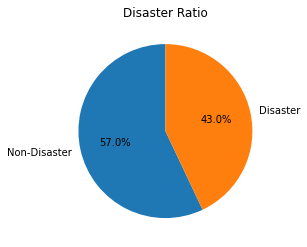

In [315]:
# Create a dataframe to show class counts
train_counts = train['target'].value_counts().reset_index()

plt.pie(train_counts['target'].values, 
        labels=['Non-Disaster', 'Disaster'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Disaster Ratio')
plt.show()

The classes look like they are balanced for the most part. We now look at the distribution of char counts. Twitter used to have a 140 character limit, which has been increase since (depending on when the data was collected)

In [316]:
train['NumberOfCharacters'] = train['text'].apply(len)

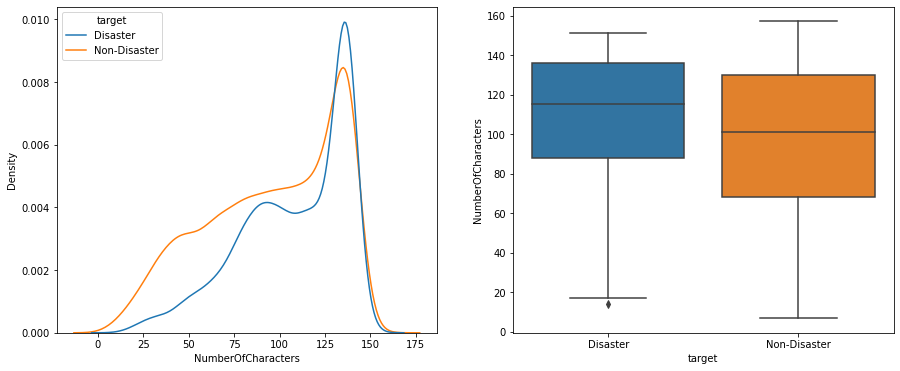

In [320]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.kdeplot(data=train,
        x='NumberOfCharacters',
        hue=train['target'].replace({0:'Non-Disaster', 1:'Disaster'}),
        ax=axs[0])

g2 = sns.boxplot(data=train,
            x=train['target'].replace({0:'Non-Disaster', 1:'Disaster'}),
            y='NumberOfCharacters',
           ax=axs[1])

The non disaster tweets in general can have lower character counts.

We do see some stop words that need to be removed, which should be a part of our pre-processing step.

Before we build our model, we need to do some additional data cleaning and text feature engineering. We'll use the SpaCy library for this.

## Model

### Lemmatize, clean and create Bag of Words 

Some stop words such as 'the', 'if' etc do not provide any classification value, these can be removed along with numbers, URLS and punctuation texts.

In [321]:
#Load a medium trained model
nlp = spacy.load("en_core_web_md")

In [330]:
def cleaner(note):
    """Remove stop words, punctuations, convert words into lemma_"""
    doc = nlp(note)
    note = (" ".join([token.lemma_ for token in doc \
                      if not token.is_stop \
                          and not token.is_punct \
                          and not token.like_num\
                          and not token.like_url\
                          and not token.like_email]))
    note = note.replace('@', '')
    note = note.lower()
    return note

In [332]:
# Clean both the training and the testing dataset, should take about a min
train['text'] = train['text'].astype(str).apply(cleaner)
test['text'] = test['text'].astype(str).apply(cleaner)

In [413]:
# Tokenize texts using keras's tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train['text'])

In [344]:
# Encode the text
encoded_train = tokenizer.texts_to_sequences(train['text'])
padded_train = keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=54, 
                                                          padding='post')

encoded_test = tokenizer.texts_to_sequences(test['text'])
padded_test = keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=54, 
                                                          padding='post')

In [345]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, train['target'], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=train['target'])

In [346]:
# Create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y_train)

### Fit a RNN Model

In [414]:
gnn_model = keras.models.Sequential([
                        keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                                               output_dim=54,
                                               input_length=X_train.shape[1]),
                        keras.layers.Bidirectional(keras.layers.SimpleRNN(64)),
                        keras.layers.Dense(64, activation='relu'),
                        keras.layers.Dense(units=1, activation='sigmoid'),
                    ])

In [415]:
gnn_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 54, 10)            149920    
                                                                 
 bidirectional_20 (Bidirecti  (None, 128)              9600      
 onal)                                                           
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 167,841
Trainable params: 167,841
Non-trainable params: 0
_________________________________________________________________


In [416]:
gnn_model.compile(loss="binary_crossentropy", # Loss function
                optimizer="adam", # Gradient Descent
                metrics=["accuracy", "AUC"])

In [417]:
gnn_model_history = gnn_model.fit(X_train, y_train,
                                    epochs=10,
                                    validation_data =(X_valid, y_valid))

Epoch 1/10
134/134 [==============================] - 3s 16ms/step - loss: 0.6709 - accuracy: 0.5833 - auc: 0.5864 - val_loss: 0.6451 - val_accuracy: 0.6071 - val_auc: 0.6857
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.5225 - accuracy: 0.7655 - auc: 0.8093 - val_loss: 0.5610 - val_accuracy: 0.7283 - val_auc: 0.7877
Epoch 3/10
134/134 [==============================] - 2s 14ms/step - loss: 0.3592 - accuracy: 0.8624 - auc: 0.9138 - val_loss: 0.6111 - val_accuracy: 0.7346 - val_auc: 0.7814
Epoch 4/10
134/134 [==============================] - 2s 14ms/step - loss: 0.2250 - accuracy: 0.9267 - auc: 0.9584 - val_loss: 0.7771 - val_accuracy: 0.7094 - val_auc: 0.7141
Epoch 5/10
134/134 [==============================] - 2s 14ms/step - loss: 0.1593 - accuracy: 0.9530 - auc: 0.9756 - val_loss: 0.7215 - val_accuracy: 0.7353 - val_auc: 0.7817
Epoch 6/10
134/134 [==============================] - 2s 15ms/step - loss: 0.1143 - accuracy: 0.9657 - auc: 0.9882 - val_loss

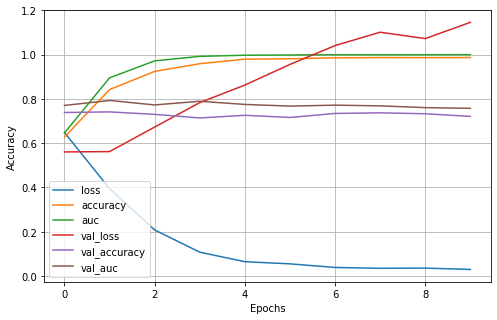

In [353]:
pd.DataFrame(gnn_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [355]:
gnn_model.evaluate(X_test, y_test)

60/60 [==============================] - 1s 9ms/step - loss: 1.0925 - accuracy: 0.7122 - auc: 0.7633


[1.0924943685531616, 0.7121848464012146, 0.7632977366447449]

As our training score improves, our validation score remains constant and the loss overshoots. This is an indicator that our model is overfitting the training data. This is also evident by the low accuracy and AUC score for the testing set we created.

### LTSM model

In [378]:
ltsm_model = keras.models.Sequential([
                        keras.layers.Embedding(len(tokenizer.word_index)+1,
                                               50,
                                               mask_zero=True),
                        keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
                        keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                        keras.layers.Dense(64, activation='sigmoid'),
                        tf.keras.layers.Dropout(0.5),
                        keras.layers.Dense(units=1, activation='sigmoid'),
                    ])

In [379]:
ltsm_model.compile(loss="binary_crossentropy", # Loss function
                optimizer=keras.optimizers.Adam(1e-2), # Gradient Descent
                metrics=["accuracy", "AUC"])

In [380]:
ltsm_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          749600    
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 128)        58880     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_40 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 1)               

In [381]:
ltsm_model_history = ltsm_model.fit(X_train, y_train,
                                    epochs=10,
                                    validation_data =(X_valid, y_valid))

Epoch 1/10
134/134 [==============================] - 22s 102ms/step - loss: 0.5773 - accuracy: 0.7195 - auc: 0.7555 - val_loss: 0.4854 - val_accuracy: 0.7836 - val_auc: 0.8300
Epoch 2/10
134/134 [==============================] - 12s 93ms/step - loss: 0.2615 - accuracy: 0.9096 - auc: 0.9523 - val_loss: 0.5560 - val_accuracy: 0.7591 - val_auc: 0.8076
Epoch 3/10
134/134 [==============================] - 14s 103ms/step - loss: 0.1318 - accuracy: 0.9580 - auc: 0.9855 - val_loss: 0.8470 - val_accuracy: 0.7444 - val_auc: 0.7888
Epoch 4/10
134/134 [==============================] - 11s 79ms/step - loss: 0.0787 - accuracy: 0.9752 - auc: 0.9937 - val_loss: 0.8791 - val_accuracy: 0.7108 - val_auc: 0.7930
Epoch 5/10
134/134 [==============================] - 9s 70ms/step - loss: 0.0535 - accuracy: 0.9829 - auc: 0.9974 - val_loss: 1.0980 - val_accuracy: 0.7150 - val_auc: 0.7823
Epoch 6/10
134/134 [==============================] - 9s 66ms/step - loss: 0.0498 - accuracy: 0.9806 - auc: 0.9981 - va

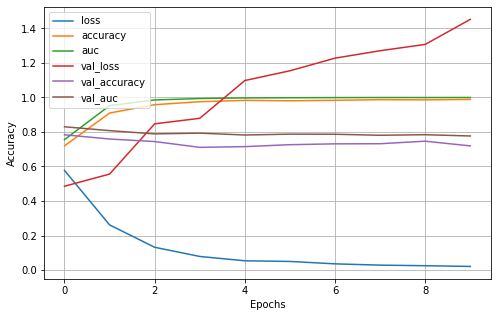

In [388]:
pd.DataFrame(ltsm_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [383]:
gnn_model.evaluate(X_test, y_test)

60/60 [==============================] - 0s 4ms/step - loss: 1.0925 - accuracy: 0.7122 - auc: 0.7633


[1.0924943685531616, 0.7121848464012146, 0.7632977366447449]

In [389]:
predictions = ltsm_model.predict(X_test)

60/60 [==============================] - 4s 14ms/step


In [411]:
print(classification_report(y_test, pd.Series(predictions[:,0]).apply(lambda x: 1 if x>.5 else 0)))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1086
           1       0.67      0.74      0.71       818

    accuracy                           0.73      1904
   macro avg       0.73      0.74      0.73      1904
weighted avg       0.74      0.73      0.74      1904



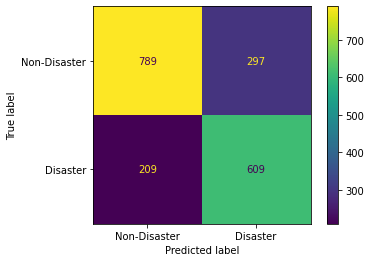

In [401]:
cf_m = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                               pd.Series(predictions[:,0]).apply(lambda x: 1 if x>.5 else 0),
                                               labels=[0, 1]),
                                               display_labels=['Non-Disaster', 'Disaster'])
cf_m.plot()

### Test Submission Predictions

In [402]:
main_test_prediction = ltsm_model.predict(padded_test)

102/102 [==============================] - 1s 14ms/step


In [408]:
ltsm_predictions = test.copy() 
ltsm_predictions['target'] = pd.Series(main_test_prediction[:,0]).apply(lambda x: 1 if x>.5 else 0)

In [410]:
ltsm_predictions[['id', 'target']].to_csv(r'predictions\unsupervised_predictions.csv', index=False)

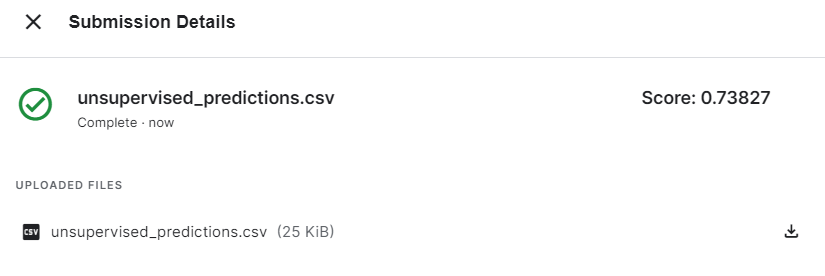

The unsupervised test public score was **0.738**

###  Fit a KNN model

We will now predict the categories using a trained KNN model

To generate our text document, we first get word counts and then calculate their tf-dif (term frequency-inverse document frequency) that will be passed onto our model. This is an important step because tf-dif helps capture relevant words that do not appear frequently throughout the document. 

In [209]:
# Bag contains a sparse matix of all document, word combinations as a 1-gram model (broken off by single words)
counter = CountVectorizer()
bag = counter.fit_transform(train['text'].values)

# Apply tf-idf technique to weight down frequent words appearing in all docs
tfidf_vec = TfidfTransformer(use_idf=True,
                             norm='l2', # Apply l2 normalization 
                             smooth_idf=True) # Assigns zero weights to terms occuring in all docs

tfidf_run = tfidf_vec.fit_transform(bag)

In [111]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [112]:
category_predictions = knn.predict(X_test)

In [113]:
accuracy_score(y_test, category_predictions)  

0.7710084033613446

In [385]:
print(classification_report(y_test, category_predictions))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1086
           1       0.83      0.59      0.69       818

    accuracy                           0.77      1904
   macro avg       0.79      0.75      0.75      1904
weighted avg       0.78      0.77      0.76      1904



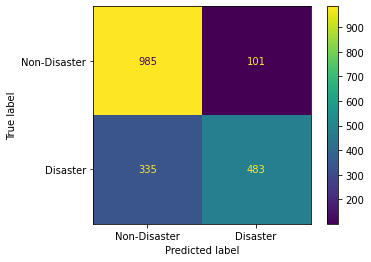

In [116]:
cf_m_sup = ConfusionMatrixDisplay(confusion_matrix(y_test, 
                                                   category_predictions,
                                                   labels=[0, 1]),
                                                   display_labels=['Non-Disaster', 'Disaster'])
cf_m_sup.plot()

### KNN - Test Submission Predictions

In [100]:
test_category_predictions = knn.predict(tfidf_test_run.toarray())

In [101]:
test_results_supervised = test.copy().assign(target=test_category_predictions)
test_results_supervised.sample(5)

,id,keyword,location,text,target
257,831,bioterror,NaN,fedex long transport bioterror germ wake anthr...,1
1317,4340,dust%20storm,The Universe,kid disappear Dust storm Atmospheric Aussie Th...,1
1256,4130,drought,NaN,water conservation urge North Thompson B.C. go...,1
3159,10480,wild%20fires,NaN,wild fire California drought state sad,1
1694,5728,forest%20fire,NaN,crew respond small brush fire burn Tahoe Fores...,0


In [102]:
test_results_supervised[['id', 'target']].to_csv(r'predictions\supervised_predictions.csv', index=False)

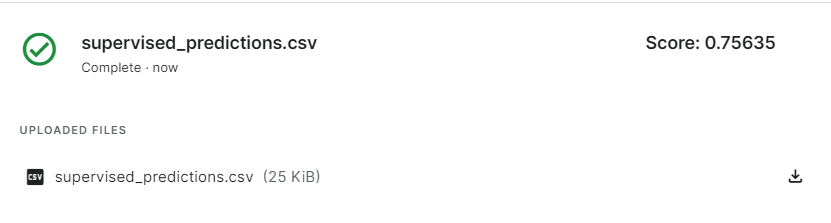

The unsupervised test public score was **0.756**

## Result, Analysis and Conclusion

Results:
The LTSM model had a score of 0.73. The plot for training vs validation accuracy and loss plots suggest that the model was over fitting the training data.  

- The model was modified by adding a Dropout layer, this helped the validation loss ever so slightly.  
- The learning rate was modified from 0.0001 to 0.01, the accuracy remained unchanged after 10 epochs but the over fitting behaviour did not however improve. 

The bidirectional RNN model achieved a score of 0.71, suggesting that the LTSM model did improve on this. 

The RNN model did not do better than the KNN one. For future exploration we could segment the hastagged keyword differently than other keywords, this might give us additional data to work with. The number of characters could also be an additional feature. In terms of the issue with generalization, additional knowledge of the word vectorization portion of the code can be helpful. This would be a good project to come back to and reanalyze after learning about Transformers.

## References


<br>Competition https://www.coursera.org/learn/introduction-to-deep-learning-boulder/peer/HYQbb/week-4-nlp-disaster-tweets-kaggle-mini-project</br>
<br>Spacy https://spacy.io/usage/spacy-101</br>
<br>ML Book https://github.com/rasbt/machine-learning-book</br>